In [1]:
import sys
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [6]:
#function reads through .fixed file, 
def read_fixed_mutations(f_fixed, chr_len, N, burnIn):
    #Create empty dict to store substitutions
    d_subs = {}
    #Loop through lined in.fixed file
    for line in f_fixed:
        #strip newline character
        line1 = line.strip('\n')
        #split line into list
        lst = line1.split()
        #Skip first two lines to move straight to data lines
        if line1[0]!="#" and lst[0]!="Mutations:" and int(lst[-1])>(N*burnIn):
            #Estimate position using decimal notation
            posn = float(lst[3])/float(chr_len)
            #Assign base position as key
            #With each line, if position occurs again, value is incremented
            #(To account for repeat mutation in the same position)
            d_subs[posn] = d_subs.get(posn, 0) + 1
    return d_subs 


In [7]:
def avg_divergence_win(d_subs, start, end, win_len):
    s_sum = 0
    for posn in d_subs.keys():
        if float(posn) <= end and float(posn) > start:
            s_sum = s_sum + 1
    return s_sum / win_len

In [8]:
def getDivergencePerGene(chr_len, totalGenes, intergenicLength, exonLength, exonsPerGene, intronLength, intronsPerGene):
    exons = []
    introns = []
    intergenic = []
    divergence = []

    geneLength = (exonLength * exonsPerGene) + (intronLength * intronsPerGene)

    for gene in range(0, totalGenes):
        geneStart = gene * (geneLength + intergenicLength) + 1
        #print(geneStart)
        for element in range(1, exonsPerGene+1):
            exonStart = geneStart + (exonLength * (element-1)) + (intronLength * (element-1))
            exonEnd = exonStart+(exonLength-1)
            exons.append([exonStart/chr_len, exonEnd/chr_len])
            #divergence.append(avg_divergence_win(d_subs, exonStart/chr_len, exonEnd/chr_len))
            #print(exonStart, exonEnd)
            if (element < exonsPerGene):
                intronStart = exonStart + exonLength
                intronEnd = intronStart+(intronLength-1)
                introns.append([intronStart/chr_len, intronEnd/chr_len])
                #divergence.append(avg_divergence_win(d_subs, intronStart/chr_len, intronEnd/chr_len))
                #print(intronStart, intronEnd)
        intergenicStart = exonEnd + 1
        intergenicEnd = intergenicStart + (intergenicLength-1)
        intergenic.append([intergenicStart/chr_len, intergenicEnd/chr_len])
        #divergence.append(avg_divergence_win(d_subs, intergenicStart/chr_len, intergenicEnd/chr_len))
        #print(intergenicStart, intergenicEnd)
        
        
    d_exons = []
    d_introns = []
    d_intergenic = []
    for i in exons:
        d_exons.append(avg_divergence_win(d_subs, i[0], i[1], exonLength))

    for i in introns:
        d_introns.append(avg_divergence_win(d_subs, i[0], i[1], intronLength))

    for i in intergenic:
        d_intergenic.append(avg_divergence_win(d_subs, i[0], i[1], intergenicLength))    
    
    g_exons = []
    g_introns = []
    g_intergenic = []

    for i in range(0, len(d_exons), 4):
        g_exons.append(np.mean(d_exons[i:i+4]))

    for i in range(0, len(d_introns), 3):
        g_introns.append(np.mean(d_introns[i:i+3]))

    for i in range(0, len(d_intergenic), 1):
        g_intergenic.append(np.mean(d_intergenic[i:i+1]))
        
    df = pd.DataFrame([g_exons, g_introns, g_intergenic]).T
    df.columns = ['exon', 'intron', 'intergenic']
    df['gene'] = df.index + 1
    df['non-coding'] = (df.intron + df.intergenic) / 2

    return(df[['gene', 'exon', 'intron', 'intergenic', 'non-coding']])

In [9]:
def get_beneficial_proportion(totalGenes,exonLength, exonsPerGene, intronLength, intronsPerGene, intergenicLength, fixedFile):
    #Create list to store exon co-ordinates
    exons = []
    #Calculate gene length
    geneLength = (exonLength * exonsPerGene) + (intronLength * intronsPerGene)
    #Loop through total number of genes
    for gene in range(0, totalGenes):
        #Get gene start
        geneStart = gene * (geneLength + intergenicLength) + 1
        #Loop through exons
        for element in range(1, exonsPerGene+1):
            #Calculate exon start and end
            exonStart = geneStart + (exonLength * (element-1)) + (intronLength * (element-1))
            exonEnd = exonStart+(exonLength-1)
            exons.append([exonStart, exonEnd])

    #Read in fixed mutations file
    fixed = pd.read_csv(fixedFile, 
                        skiprows=2, 
                        sep=' ',
                       names=['tempID', 'permID', 'mutType', 'location', 's', 'h', 'initial_subpop', 'origin_gen',
                             'fix_gen'])
    #Create empty df for concatenating dfs
    fdf = pd.DataFrame()
    #Loop through exons, keeping only mutations that fall within exonic regions
    for i in range(0, len(exons)):
        tdf = fixed[(fixed.location>=(exons[i][0])) & (fixed.location<(exons[i][1]))]
        fdf = pd.concat([fdf,tdf])
    #Calculate proportion of beneficials in coding regions, and proportion of all mutations    
    coding = len(fdf[fdf.mutType=='m0'])/len(fdf)
    allMuts = len(fixed[fixed.mutType=='m0'])/len(fixed)

    return([coding, allMuts])

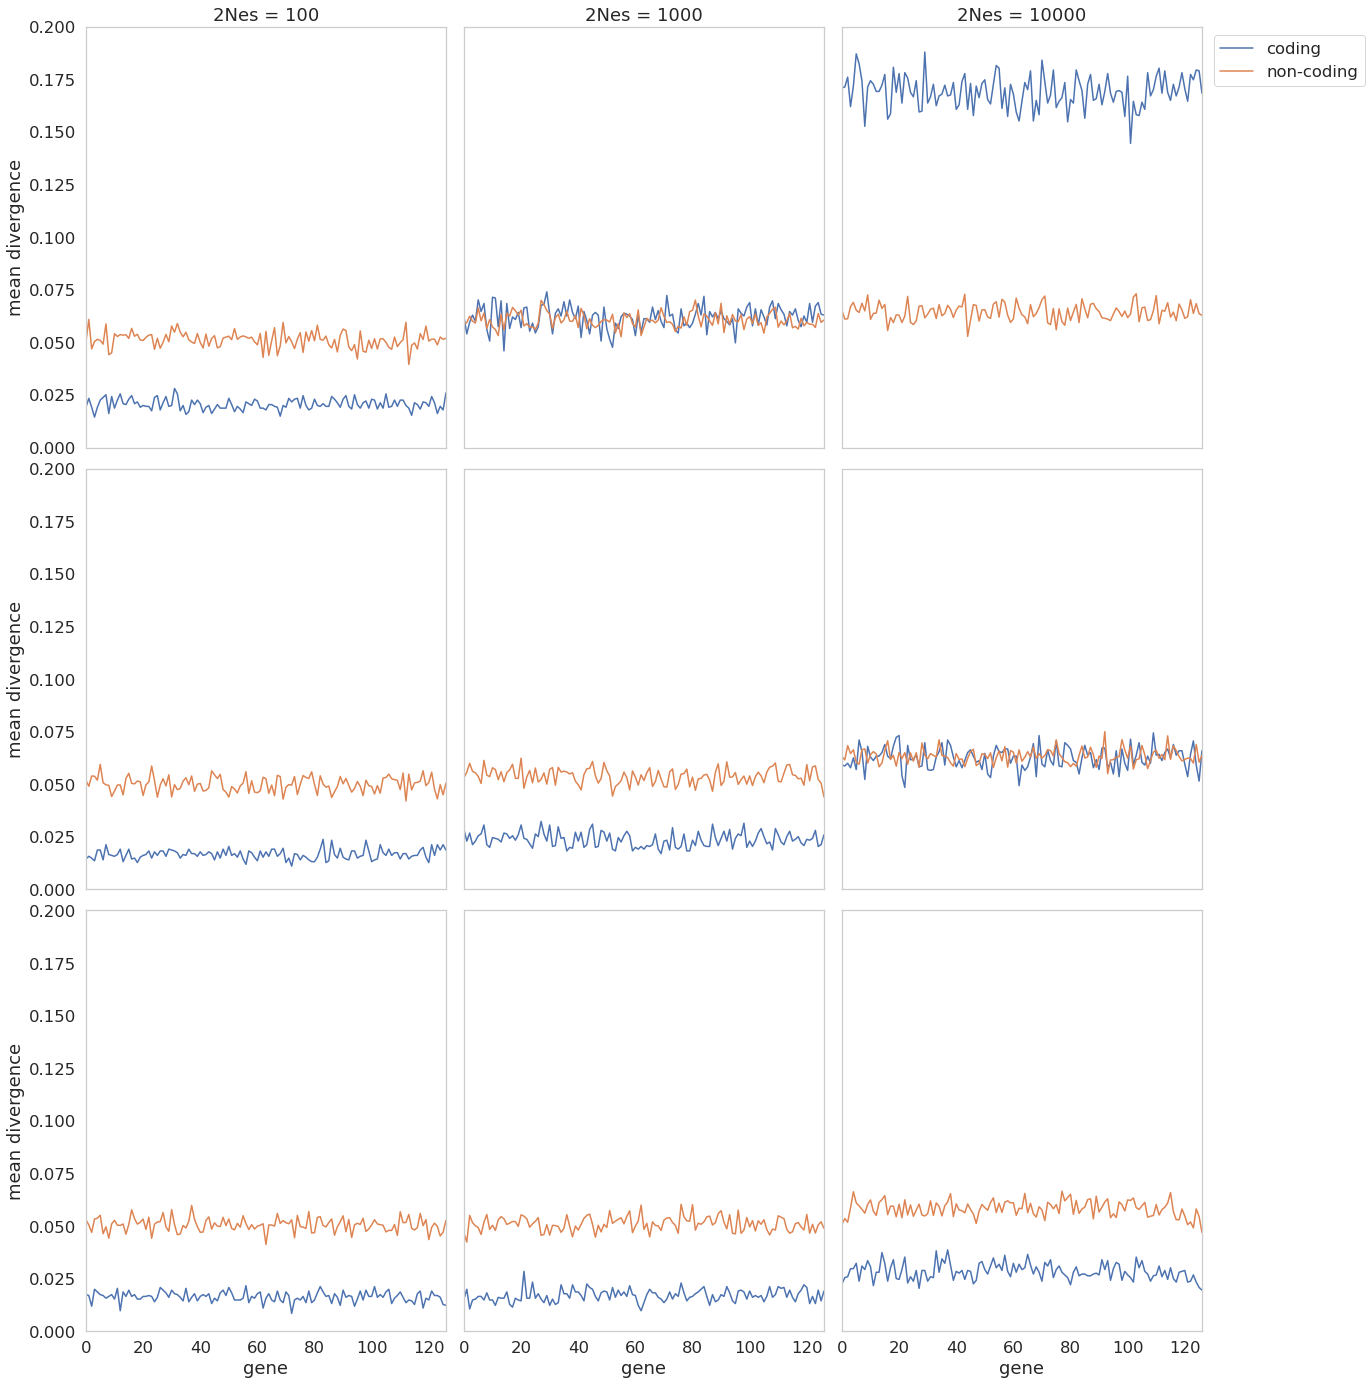

In [17]:
#Set parameters to extract coding and non-coding regions (ie inputs for getDivergencePerGene function)
chr_len = 997204
totalGenes = 127
intergenicLength = 3811
exonLength = 588
exonsPerGene = 4
intronLength = 563
intronsPerGene = 3 
c=0
#Set up plot
sns.set(rc={'figure.figsize':(20,24),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.5)
#Loop through beneficial proportion of DFE values
for a,b in enumerate([0.05, 0.005, 0.0005]):
    #Read in fixed mutations
    for i,j in enumerate(['100', '1000', '10000']):
        c+=1
        f_file = fixedPath+str(b)+ ".fixed" 
        f_subs = open(f_file, 'r')
        #Function extracts fixed mutations from file
        d_subs = read_fixed_mutations(f_subs, chr_len)
        #Function calculates divergence per gene
        df =  getDivergencePerGene(chr_len, totalGenes, intergenicLength, exonLength, exonsPerGene, intronLength, intronsPerGene)

        plt.subplot(3,3,c)  
        plt.plot(df.exon, label='coding')
        plt.plot(df['non-coding'], label='non-coding')
        plt.margins(x=0)
        if(b==0.0005):
            plt.xlabel('gene')
        elif(b==0.05):
            plt.xticks([])
            plt.title('2Nes = ' + j)
            if(i==2):
                plt.legend(bbox_to_anchor=(1.01, 1))
        else:
            plt.xticks([])
            
        plt.ylim([0,0.2])
        if(i==0):
            plt.ylabel('mean divergence')    
        else:
            plt.yticks([])

    #Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)